In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

**selecting necessary data**

In [32]:
#top 30 variables

topvars = pd.read_csv('top_30_vars.csv')
topvars = list(topvars.variable.values)

#all data
data = pd.read_csv('card_transactions_all_features.csv')

In [34]:
columnskeep = topvars + ['Recnum','Date','Fraud']
len(columnskeep)

33

In [38]:
df = data[columnskeep]

In [39]:
df.head()

,Cardnum_max_14,Cardnum_max_30,Cardnum_mean_30,Cardnum_total_130,Cardnum_total_30,Merchnum_mean_1,Merchnum_mean_3,Merchnum_mean_7,Merchnum_total_3,card_merchant_max_14,...,card_state_total_30,card_zip_max_14,card_zip_max_30,card_zip_max_7,card_zip_mean_1,card_zip_mean_7,card_zip_median_1,Recnum,Date,Fraud
0,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,2010-01-01,0
1,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2,2010-01-01,0
2,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,2010-01-01,0
3,0.00,0.00,0.00,NaN,0.00,3.62,3.62,3.62,3.62,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4,2010-01-01,0
4,3.62,3.62,3.62,30.0,3.62,3.62,3.62,3.62,7.24,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,2010-01-01,0


In [66]:
df = df.fillna(0)

**splitting modeling and oot data**

In [91]:
main_Xs = topvars

#oot df
df_oot = df[df.Date>='2010-11-01'].copy()

#x and y oot
y_oot = df_oot['Fraud'].copy()
X_oot = df_oot.copy().drop(columns='Fraud')

#modeling data
df_model = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].copy()

# #x and y train
y = df_model['Fraud'].copy()
X = df_model.copy().drop(columns='Fraud')

# #dropping date and record
df_oot.drop(columns=['Date','Recnum'], inplace=True)
y_oot.drop(columns=['Date','Recnum'], inplace=True)
X_oot.drop(columns=['Date','Recnum'], inplace=True)
df_model.drop(columns=['Date','Recnum'], inplace=True)
y.drop(columns=['Date','Recnum'], inplace=True)
X.drop(columns=['Date','Recnum'], inplace=True)

X_oot = StandardScaler().fit_transform(X_oot)
X = StandardScaler().fit_transform(X)

In [69]:
#caclulate fdr at 3%

def calculateFDR(predict, fraudscore, y):
    temp = pd.DataFrame({'true':y.tolist(), 'predict':predict, 'score':fraudscore})
    temp.sort_values('score', ascending=False, inplace=True)
    percent3 = int(len(predict)*0.03)
    return np.sum(temp.true[0:percent3])/np.sum(temp.true)

In [70]:
#messager for when algorithms are done

from twilio.rest import Client 

account_sid = 'ACcaa43961ddf226f48ab29089dbaccac0' 
auth_token = '7c1378126e60e485165e515853ef09b9' 
client = Client(account_sid, auth_token) 

def sendSignaltoChatBot():
    signalm = f"Model is done running."
    message = client.messages.create( 
                                  from_='whatsapp:+14155238886',  
                                  body=signalm,      
                                  to='whatsapp:+12094809788') 
    print(message.sid) 

**Random Forest**

In [71]:
def randomforestFDR(X, X_oot, y, y_oot, iteration=10, n_estimators=50, max_features=10, max_depth=20):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
    
    fdr_df=[]
    fdr_total=[0,0,0]
    for i in range(iteration):
        X_train, X_test, y_train, y_test = train_test_split(X, y) # using default setting for test_size(0.25), random_state(None) and shuffle(True)
        rf.fit(X_train, y_train)
        
        data = [[X_train, y_train], [X_test, y_test], [X_oot, y_oot]]
        fdr_list=[]
        for d in range(len(data)):
            predict = rf.predict(data[d][0])
            prob = rf.predict_proba(data[d][0])
            fraudscore = prob.transpose()[1]
            fdr_each = calculateFDR(predict, fraudscore, data[d][1])
            fdr_total[d] += fdr_each
            fdr_list.append(fdr_each)
        
        fdr_df.append(fdr_list)
    
    avg_train = fdr_total[0] / iteration
    avg_test = fdr_total[1] / iteration
    avg_oot = fdr_total[2] / iteration
    result = [avg_train, avg_test, avg_oot]

    return fdr_df, result

In [92]:
# Adjusting hyperparameters
tree = [50,100,150] # towarddatascience guide: 200~2000
features = [5,10,15,20] # should be less than number of variables (original choice: [5,10,15,20])
depth = [10,20,50] # towarddatascience guide: 10~110 (original choice: [10,20,50,100])

maximum = 0
params=[]
fdr_all=[]
fdr_mean=[]
for i in tree:
    for j in features:
        for k in depth:
            temp1, temp2 = randomforestFDR(X, X_oot, y, y_oot, iteration=10, n_estimators=i, max_features=j, max_depth=k) # optimizing on test data
            params.append([i,j,k])
            fdr_mean.append(temp2)
            fdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum=temp2[1]
                maxfdr=temp2
                maxparams=[i,j,k]
                
print(f'n_estimators: {maxparams[0]}, max_features: {maxparams[1]}, max_depth: {maxparams[2]} with fdr: {maximum} on the test data')

n_estimators: 100, max_features: 10, max_depth: 50 with fdr: 0.9012589333086674 on the test data


In [93]:
sendSignaltoChatBot()

SMdb3fbbc371be41b1a3a7746bdc226351


In [94]:
output30 = pd.DataFrame({'params':params, 'fdr':fdr_mean})
output30_alliter = pd.DataFrame(fdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(fdr_all)):
    output30_alliter = pd.concat([output30_alliter, pd.DataFrame(fdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)
output30

,params,fdr
0,"[50, 5, 10]","[0.89755270779842, 0.8294602338163406, 0.26312..."
1,"[50, 5, 20]","[0.9946487397589123, 0.883232551761451, 0.3418..."
2,"[50, 5, 50]","[0.9957275328521241, 0.8878827318618441, 0.366..."
3,"[50, 10, 10]","[0.9176289119647896, 0.8421373191220317, 0.315..."
4,"[50, 10, 20]","[0.9961559415705615, 0.873518970658402, 0.3681..."
5,"[50, 10, 50]","[0.9956938735090315, 0.878652611673742, 0.3687..."
6,"[50, 15, 10]","[0.9262646394240868, 0.847223540729501, 0.3424..."
7,"[50, 15, 20]","[0.9960060189111525, 0.8866171899232793, 0.386..."
8,"[50, 15, 50]","[0.9957690089108517, 0.8858754404220945, 0.377..."
9,"[50, 20, 10]","[0.9273406048935542, 0.8441608643791765, 0.337..."


In [98]:
output30_alliter

,"[50, 5, 10]: train",test,oot,"[50, 5, 20]: train",test,oot,"[50, 5, 50]: train",test,oot,"[50, 10, 10]: train",...,oot,"[150, 20, 10]: train",test,oot,"[150, 20, 20]: train",test,oot,"[150, 20, 50]: train",test,oot
0,0.892188,0.837719,0.256983,0.993701,0.866953,0.346369,0.996997,0.866337,0.324022,0.911315,...,0.379888,0.943307,0.828326,0.374302,0.996918,0.881279,0.430168,0.993808,0.887387,0.402235
1,0.906203,0.830918,0.268156,0.993985,0.886700,0.418994,0.995434,0.895735,0.346369,0.911677,...,0.340782,0.928013,0.868996,0.312849,0.993921,0.895238,0.368715,0.993750,0.899123,0.407821
2,0.862928,0.831858,0.256983,0.993865,0.893519,0.391061,0.995238,0.899160,0.262570,0.919818,...,0.424581,0.940625,0.833333,0.391061,0.995468,0.902913,0.357542,0.993856,0.861751,0.379888
3,0.910494,0.859091,0.245810,0.995327,0.884956,0.379888,0.995413,0.920561,0.374302,0.906805,...,0.351955,0.932927,0.853774,0.296089,0.993994,0.891089,0.413408,0.993874,0.920930,0.368715
4,0.889058,0.819048,0.223464,0.993837,0.908676,0.396648,0.996979,0.883495,0.312849,0.915280,...,0.391061,0.933744,0.885845,0.324022,0.998442,0.867257,0.418994,0.996928,0.884793,0.430168
5,0.914504,0.826291,0.251397,0.993912,0.895735,0.391061,0.995461,0.874396,0.391061,0.933962,...,0.424581,0.933227,0.857741,0.357542,0.995482,0.897059,0.368715,0.996937,0.906977,0.357542
6,0.890555,0.815920,0.290503,0.993939,0.879808,0.251397,0.993912,0.914692,0.424581,0.930663,...,0.379888,0.940909,0.822115,0.402235,0.995399,0.893519,0.363128,0.996909,0.837104,0.351955
7,0.897991,0.855204,0.262570,0.995509,0.860000,0.268156,0.995468,0.902913,0.418994,0.920188,...,0.418994,0.925984,0.858369,0.396648,0.993837,0.926941,0.351955,0.995406,0.879070,0.357542
8,0.915902,0.803738,0.268156,0.996965,0.880383,0.262570,0.995413,0.869159,0.413408,0.902669,...,0.413408,0.925581,0.874439,0.391061,0.996909,0.891403,0.363128,0.993808,0.878378,0.357542
9,0.895706,0.814815,0.307263,0.995448,0.875598,0.312849,0.996960,0.852381,0.396648,0.923913,...,0.363128,0.926718,0.882629,0.391061,0.995238,0.894958,0.385475,0.995349,0.892377,0.346369


In [99]:
output30.to_csv('rf_30vars_mean.csv')
output30_alliter.to_csv('rf_30vars_all.csv')

**Neural Net**

In [109]:
#trying to change nodes

nn_df = pd.DataFrame(columns=['TRAIN', 'TEST', 'OOT'])

def neuralnet(X, X_oot, y, y_oot, epoch, hidden_layer_sizes, iterations=10):
    kf = KFold(n_splits=4, shuffle=True)
    nn = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, max_iter = epoch)
    
    nnfdr_df = []
    nnfdr_total=[0,0,0] # train, test, oot    
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y) # using default setting for test_size(0.25), random_state(None) and shuffle(True)
        nn.fit(X_train, y_train)
        
        data = [[X_train, y_train], [X_test, y_test], [X_oot, y_oot]]
        nnfdr_list=[]
        for d in range(len(data)):
            predict = nn.predict(data[d][0])
            prob = nn.predict_proba(data[d][0])
            fraudscore = prob.transpose()[1]
            nnfdr_each = calculateFDR(predict, fraudscore, data[d][1])
            nnfdr_total[d] += nnfdr_each
            nnfdr_list.append(nnfdr_each)
        nnfdr_df.append(nnfdr_list)
        
    avg_train = nnfdr_total[0] / iterations
    avg_test = nnfdr_total[1] / iterations
    avg_oot = nnfdr_total[2] / iterations
    result = [avg_train, avg_test, avg_oot]
    
    return nnfdr_df, result

In [110]:
#trying to change nodes

# Adjusting epochs
epoch = [i for i in range(0,51,10) if i!=0]
nodes = [10,20,30,40]

maximum = 0
params = []
nnfdr_all = []
nnfdr_mean = []

for i in epoch:
    for j in nodes:
            temp1, temp2 = neuralnet(X, X_oot, y, y_oot, epoch=i, hidden_layer_sizes=(j,), iterations=10) # optimizing on test data
            params.append([i,j])
            nnfdr_mean.append(temp2)
            nnfdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum = temp2[1]
                maxfdr=temp2
                maxparams = [i,j]
            print(f'model {i} epochs, {j} nodes: done')
                  
print(f'epochs: {maxparams[0]}, nodes: {maxparams[1]} with fdr {maximum} on the test data')

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes: done
epochs: 50, nodes: 40 with fdr 0.7528645140462369 on the test data


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [111]:
sendSignaltoChatBot()

SM244ff2c1e6c54dca99b903dd316ed75e


In [112]:
nnoutput30 = pd.DataFrame({'params':params, 'fdr':nnfdr_mean})
nnoutput30_alliter = pd.DataFrame(nnfdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(nnfdr_all)):
    nnoutput30_alliter = pd.concat([nnoutput30_alliter, pd.DataFrame(nnfdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [113]:
nnoutput30

,params,fdr
0,"[10, 10]","[0.6427102426825326, 0.6307380113655847, 0.341..."
1,"[10, 20]","[0.6655166386720852, 0.6325638569185096, 0.379..."
2,"[10, 30]","[0.6793399434936884, 0.6592867378820783, 0.387..."
3,"[10, 40]","[0.6896676263819879, 0.6528271881307847, 0.423..."
4,"[20, 10]","[0.6807637501678493, 0.6462140061114022, 0.373..."
5,"[20, 20]","[0.7002534137882411, 0.6851038265026592, 0.405..."
6,"[20, 30]","[0.7249488993729234, 0.687030879386914, 0.4720..."
7,"[20, 40]","[0.7229779249152876, 0.6995465514036934, 0.475..."
8,"[30, 10]","[0.6854432151365185, 0.6751609652485083, 0.384..."
9,"[30, 20]","[0.725672857721982, 0.6963657862246343, 0.4268..."


In [114]:
nnoutput30_alliter

,"[10, 10]: train",test,oot,"[10, 20]: train",test,oot,"[10, 30]: train",test,oot,"[10, 40]: train",...,oot,"[50, 20]: train",test,oot,"[50, 30]: train",test,oot,"[50, 40]: train",test,oot
0,0.658055,0.604762,0.318436,0.667180,0.639269,0.312849,0.684129,0.671233,0.318436,0.714919,...,0.525140,0.747734,0.703883,0.530726,0.790447,0.776256,0.491620,0.792647,0.755319,0.486034
1,0.673375,0.639640,0.374302,0.691729,0.620690,0.284916,0.685670,0.657534,0.374302,0.694228,...,0.374302,0.772939,0.688889,0.508380,0.787136,0.716279,0.513966,0.785824,0.762557,0.480447
2,0.653963,0.669811,0.290503,0.641593,0.678947,0.441341,0.663093,0.646512,0.435754,0.689548,...,0.441341,0.760062,0.725225,0.508380,0.800000,0.788462,0.530726,0.799378,0.768889,0.491620
3,0.645511,0.590090,0.368715,0.679878,0.636792,0.374302,0.695719,0.635514,0.357542,0.679811,...,0.396648,0.755656,0.756098,0.519553,0.754224,0.751152,0.446927,0.770468,0.717391,0.513966
4,0.645062,0.640909,0.340782,0.682515,0.634259,0.391061,0.685325,0.681159,0.452514,0.694864,...,0.541899,0.777434,0.746606,0.541899,0.775542,0.810811,0.541899,0.799373,0.760870,0.480447
5,0.674961,0.635556,0.335196,0.654709,0.643216,0.357542,0.671340,0.676991,0.351955,0.704160,...,0.491620,0.787970,0.699507,0.480447,0.772586,0.716814,0.497207,0.762791,0.798206,0.519553
6,0.588872,0.683258,0.318436,0.644377,0.642857,0.474860,0.672840,0.668182,0.385475,0.667660,...,0.458101,0.740741,0.668182,0.290503,0.820433,0.725225,0.502793,0.786708,0.728507,0.569832
7,0.608828,0.620853,0.290503,0.640625,0.587719,0.312849,0.658879,0.672566,0.396648,0.690909,...,0.541899,0.763720,0.707547,0.407821,0.773900,0.722488,0.458101,0.778287,0.775701,0.513966
8,0.662058,0.576037,0.279330,0.665644,0.666667,0.441341,0.689382,0.611814,0.396648,0.687011,...,0.435754,0.770865,0.746411,0.497207,0.775449,0.700000,0.536313,0.781931,0.743363,0.491620
9,0.616418,0.646465,0.502793,0.686916,0.575221,0.402235,0.687023,0.671362,0.402235,0.673567,...,0.469274,0.760060,0.736041,0.452514,0.784522,0.765550,0.324022,0.807018,0.717842,0.547486


In [115]:
nnoutput30.to_csv('nn_30vars_mean.csv')
nnoutput30_alliter.to_csv('nn_30vars_all.csv')

## Changing test size to .3

In [118]:
def randomforestFDR2(X, X_oot, y, y_oot, iteration=10, n_estimators=50, max_features=10, max_depth=20):
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
    
    fdr_df=[]
    fdr_total=[0,0,0]
    for i in range(iteration):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.3) # using default setting for random_state(None) and shuffle(True)
        rf.fit(X_train, y_train)
        
        data = [[X_train, y_train], [X_test, y_test], [X_oot, y_oot]]
        fdr_list=[]
        for d in range(len(data)):
            predict = rf.predict(data[d][0])
            prob = rf.predict_proba(data[d][0])
            fraudscore = prob.transpose()[1]
            fdr_each = calculateFDR(predict, fraudscore, data[d][1])
            fdr_total[d] += fdr_each
            fdr_list.append(fdr_each)
        
        fdr_df.append(fdr_list)
    
    avg_train = fdr_total[0] / iteration
    avg_test = fdr_total[1] / iteration
    avg_oot = fdr_total[2] / iteration
    result = [avg_train, avg_test, avg_oot]

    return fdr_df, result

In [119]:
# Adjusting hyperparameters
tree = [50,100,150] # towarddatascience guide: 200~2000
features = [5,10,15,20] # should be less than number of variables (original choice: [5,10,15,20])
depth = [10,20,50] # towarddatascience guide: 10~110 (original choice: [10,20,50,100])

maximum = 0
params=[]
fdr_all=[]
fdr_mean=[]
for i in tree:
    for j in features:
        for k in depth:
            temp1, temp2 = randomforestFDR2(X, X_oot, y, y_oot, iteration=10, n_estimators=i, max_features=j, max_depth=k) # optimizing on test data
            params.append([i,j,k])
            fdr_mean.append(temp2)
            fdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum=temp2[1]
                maxfdr=temp2
                maxparams=[i,j,k]
                
print(f'n_estimators: {maxparams[0]}, max_features: {maxparams[1]}, max_depth: {maxparams[2]} with fdr: {maximum} on the test data')

n_estimators: 100, max_features: 20, max_depth: 20 with fdr: 0.896702318976527 on the test data


In [120]:
sendSignaltoChatBot()

SM3e3451ad1def440185ad1e86a0052c62


In [121]:
output30 = pd.DataFrame({'params':params, 'fdr':fdr_mean})
output30_alliter = pd.DataFrame(fdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(fdr_all)):
    output30_alliter = pd.concat([output30_alliter, pd.DataFrame(fdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [122]:
output30.to_csv('rf_30vars_mean2.csv')
output30_alliter.to_csv('rf_30vars_all2.csv')

In [123]:
#trying to change nodes

nn_df = pd.DataFrame(columns=['TRAIN', 'TEST', 'OOT'])

def neuralnet2(X, X_oot, y, y_oot, epoch, hidden_layer_sizes, iterations=10):
    kf = KFold(n_splits=4, shuffle=True)
    nn = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, max_iter = epoch)
    
    nnfdr_df = []
    nnfdr_total=[0,0,0] # train, test, oot    
    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) # using default setting for random_state(None) and shuffle(True)
        nn.fit(X_train, y_train)
        
        data = [[X_train, y_train], [X_test, y_test], [X_oot, y_oot]]
        nnfdr_list=[]
        for d in range(len(data)):
            predict = nn.predict(data[d][0])
            prob = nn.predict_proba(data[d][0])
            fraudscore = prob.transpose()[1]
            nnfdr_each = calculateFDR(predict, fraudscore, data[d][1])
            nnfdr_total[d] += nnfdr_each
            nnfdr_list.append(nnfdr_each)
        nnfdr_df.append(nnfdr_list)
        
    avg_train = nnfdr_total[0] / iterations
    avg_test = nnfdr_total[1] / iterations
    avg_oot = nnfdr_total[2] / iterations
    result = [avg_train, avg_test, avg_oot]
    
    return nnfdr_df, result

In [124]:
#trying to change nodes

# Adjusting epochs
epoch = [i for i in range(0,51,10) if i!=0]
nodes = [10,20,30,40]

maximum = 0
params = []
nnfdr_all = []
nnfdr_mean = []

for i in epoch:
    for j in nodes:
            temp1, temp2 = neuralnet2(X, X_oot, y, y_oot, epoch=i, hidden_layer_sizes=(j,), iterations=10) # optimizing on test data
            params.append([i,j])
            nnfdr_mean.append(temp2)
            nnfdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum = temp2[1]
                maxfdr=temp2
                maxparams = [i,j]
            print(f'model {i} epochs, {j} nodes: done')
                  
print(f'epochs: {maxparams[0]}, nodes: {maxparams[1]} with fdr {maximum} on the test data')

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes: done
epochs: 50, nodes: 40 with fdr 0.7520209286125155 on the test data


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [125]:
sendSignaltoChatBot()

SMc2f2ac635f134a4fbcb0f128b4622730


In [126]:
nnoutput30 = pd.DataFrame({'params':params, 'fdr':nnfdr_mean})
nnoutput30_alliter = pd.DataFrame(nnfdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(nnfdr_all)):
    nnoutput30_alliter = pd.concat([nnoutput30_alliter, pd.DataFrame(nnfdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [127]:
nnoutput30.to_csv('nn_30vars_mean2.csv')
nnoutput30_alliter.to_csv('nn_30vars_all2.csv')

## 10 vars, test size = .3

In [128]:
top10vars = [
'Cardnum_max_30',
'card_merchant_max_30',
'Merchnum_total_3',
'Cardnum_total_130',
'Merchnum_mean_7',
'card_merchant_median_1',
'Merchnum_mean_3',
'Cardnum_mean_30',
'card_merchant_mean_1',
'card_state_mean_30']

In [138]:
main_Xs = top10vars

#oot df
df_oot = df[df.Date>='2010-11-01'].copy()

#x and y oot
y_oot = df_oot['Fraud'].copy()
X_oot = df_oot.copy().drop(columns='Fraud')

#modeling data
df_model = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].copy()

# #x and y train
y = df_model['Fraud'].copy()
X = df_model.copy().drop(columns='Fraud')

# #dropping date and record
df_oot.drop(columns=['Date','Recnum'], inplace=True)
y_oot.drop(columns=['Date','Recnum'], inplace=True)
X_oot.drop(columns=['Date','Recnum'], inplace=True)

df_model.drop(columns=['Date','Recnum'], inplace=True)
y.drop(columns=['Date','Recnum'], inplace=True)
X.drop(columns=['Date','Recnum'], inplace=True)

X_oot2 = X_oot[top10vars]
X2 = X[top10vars]

X_oot2 = StandardScaler().fit_transform(X_oot2)
X2 = StandardScaler().fit_transform(X2)

In [140]:
# Adjusting hyperparameters
tree = [50,100,150] # towarddatascience guide: 200~2000
features = [5,10] # should be less than number of variables (original choice: [5,10,15,20])
depth = [10,20,50] # towarddatascience guide: 10~110 (original choice: [10,20,50,100])

maximum = 0
params=[]
fdr_all=[]
fdr_mean=[]
for i in tree:
    for j in features:
        for k in depth:
            temp1, temp2 = randomforestFDR2(X2, X_oot2, y, y_oot, iteration=10, n_estimators=i, max_features=j, max_depth=k) # optimizing on test data
            params.append([i,j,k])
            fdr_mean.append(temp2)
            fdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum=temp2[1]
                maxfdr=temp2
                maxparams=[i,j,k]
                
print(f'n_estimators: {maxparams[0]}, max_features: {maxparams[1]}, max_depth: {maxparams[2]} with fdr: {maximum} on the test data')

n_estimators: 100, max_features: 5, max_depth: 50 with fdr: 0.8935677382272041 on the test data


In [141]:
sendSignaltoChatBot()

SM1367575ccd5b48599194177bc8444c46


In [142]:
output10 = pd.DataFrame({'params':params, 'fdr':fdr_mean})
output10_alliter = pd.DataFrame(fdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(fdr_all)):
    output10_alliter = pd.concat([output10_alliter, pd.DataFrame(fdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [143]:
output10.to_csv('rf_10vars_mean2.csv')
output10_alliter.to_csv('rf_10vars_all2.csv')

In [144]:
#trying to change nodes

# Adjusting epochs
epoch = [i for i in range(0,51,10) if i!=0]
nodes = [10,20,30,40]

maximum = 0
params = []
nnfdr_all = []
nnfdr_mean = []

for i in epoch:
    for j in nodes:
            temp1, temp2 = neuralnet2(X2, X_oot2, y, y_oot, epoch=i, hidden_layer_sizes=(j,), iterations=10) # optimizing on test data
            params.append([i,j])
            nnfdr_mean.append(temp2)
            nnfdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum = temp2[1]
                maxfdr=temp2
                maxparams = [i,j]
            print(f'model {i} epochs, {j} nodes: done')
                  
print(f'epochs: {maxparams[0]}, nodes: {maxparams[1]} with fdr {maximum} on the test data')

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes: done
epochs: 50, nodes: 30 with fdr 0.6732726274820802 on the test data


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [145]:
sendSignaltoChatBot()

SM598fd3ddf1c14fe6afb3f7e9c3f4d6dc


In [146]:
nnoutput10 = pd.DataFrame({'params':params, 'fdr':nnfdr_mean})
nnoutput10_alliter = pd.DataFrame(nnfdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(nnfdr_all)):
    nnoutput10_alliter = pd.concat([nnoutput10_alliter, pd.DataFrame(nnfdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [147]:
nnoutput10.to_csv('nn_10vars_mean2.csv')
nnoutput10_alliter.to_csv('nn_10vars_all2.csv')

## 20 Vars, test size .3 ##

In [148]:
top20vars = [
    'Cardnum_max_30',
'card_merchant_max_30',
'Merchnum_total_3',
'Cardnum_total_130',
'Merchnum_mean_7',
'card_merchant_median_1',
'Merchnum_mean_3',
'Cardnum_mean_30',
'card_merchant_mean_1',
'card_state_mean_30',
'card_state_median_30',
'card_zip_median_1',
'card_state_mean_14',
'Cardnum_max_14',
'card_state_max_0',
'Cardnum_total_30',
'card_zip_mean_1',
'card_state_median_14',
'card_zip_max_14',
'card_state_total_30'
]

In [151]:
main_Xs = top10vars

#oot df
df_oot = df[df.Date>='2010-11-01'].copy()

#x and y oot
y_oot = df_oot['Fraud'].copy()
X_oot = df_oot.copy().drop(columns='Fraud')

#modeling data
df_model = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].copy()

# #x and y train
y = df_model['Fraud'].copy()
X = df_model.copy().drop(columns='Fraud')

# #dropping date and record
df_oot.drop(columns=['Date','Recnum'], inplace=True)
y_oot.drop(columns=['Date','Recnum'], inplace=True)
X_oot.drop(columns=['Date','Recnum'], inplace=True)

df_model.drop(columns=['Date','Recnum'], inplace=True)
y.drop(columns=['Date','Recnum'], inplace=True)
X.drop(columns=['Date','Recnum'], inplace=True)

X_oot3 = X_oot[top20vars]
X3 = X[top20vars]

X_oot3 = StandardScaler().fit_transform(X_oot3)
X3 = StandardScaler().fit_transform(X3)

In [152]:
# Adjusting hyperparameters
tree = [50,100,150] # towarddatascience guide: 200~2000
features = [5,10] # should be less than number of variables (original choice: [5,10,15,20])
depth = [10,20,50] # towarddatascience guide: 10~110 (original choice: [10,20,50,100])

maximum = 0
params=[]
fdr_all=[]
fdr_mean=[]
for i in tree:
    for j in features:
        for k in depth:
            temp1, temp2 = randomforestFDR2(X3, X_oot3, y, y_oot, iteration=10, n_estimators=i, max_features=j, max_depth=k) # optimizing on test data
            params.append([i,j,k])
            fdr_mean.append(temp2)
            fdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum=temp2[1]
                maxfdr=temp2
                maxparams=[i,j,k]
                
print(f'n_estimators: {maxparams[0]}, max_features: {maxparams[1]}, max_depth: {maxparams[2]} with fdr: {maximum} on the test data')

n_estimators: 150, max_features: 5, max_depth: 20 with fdr: 0.8919531789304077 on the test data


In [153]:
sendSignaltoChatBot()

SM5b5645c47ee1476eb4f6ef35a29a3a08


In [154]:
output20 = pd.DataFrame({'params':params, 'fdr':fdr_mean})
output20_alliter = pd.DataFrame(fdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(fdr_all)):
    output20_alliter = pd.concat([output20_alliter, pd.DataFrame(fdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [155]:
output20.to_csv('rf_20vars_mean.csv')
output20_alliter.to_csv('rf_20vars_all.csv')

In [156]:
#trying to change nodes

# Adjusting epochs
epoch = [i for i in range(0,51,10) if i!=0]
nodes = [10,20,30,40]

maximum = 0
params = []
nnfdr_all = []
nnfdr_mean = []

for i in epoch:
    for j in nodes:
            temp1, temp2 = neuralnet2(X3, X_oot3, y, y_oot, epoch=i, hidden_layer_sizes=(j,), iterations=10) # optimizing on test data
            params.append([i,j])
            nnfdr_mean.append(temp2)
            nnfdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum = temp2[1]
                maxfdr=temp2
                maxparams = [i,j]
            print(f'model {i} epochs, {j} nodes: done')
                  
print(f'epochs: {maxparams[0]}, nodes: {maxparams[1]} with fdr {maximum} on the test data')

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimi

model 10 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimi

model 20 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimi

model 30 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimi

model 40 epochs, 40 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes: done
epochs: 40, nodes: 40 with fdr 0.7400835810350529 on the test data


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [157]:
sendSignaltoChatBot()

SM7d3a53f6c6f442bcba88a1895eab0e6a


In [158]:
nnoutput20 = pd.DataFrame({'params':params, 'fdr':nnfdr_mean})
nnoutput20_alliter = pd.DataFrame(nnfdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(nnfdr_all)):
    nnoutput20_alliter = pd.concat([nnoutput20_alliter, pd.DataFrame(nnfdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)

In [159]:
nnoutput20.to_csv('nn_20vars_mean.csv')
nnoutput20_alliter.to_csv('nn_20vars_all.csv')

In [795]:
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network._multilayer_perceptron:

class MLPClassifier(sklearn.base.ClassifierMixin, BaseMultilayerPerceptron)
 |  MLPClassifier(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity

In [796]:
#trying to change nodes

# Adjusting epochs
epoch = [i for i in range(50,81,10) if i!=0]
nodes = [10,20,30,40]

maximum = 0
params = []
nnfdr_all = []
nnfdr_mean = []

for i in epoch:
    for j in nodes:
        for k in nodes:
            temp1, temp2 = neuralnet2(X3, X_oot3, y, y_oot, epoch=i, hidden_layer_sizes=(j,k), iterations=10) # optimizing on test data
            params.append([i,j,k])
            nnfdr_mean.append(temp2)
            nnfdr_all.append(temp1)
            if maximum < temp2[1]:
                maximum = temp2[1]
                maxfdr=temp2
                maxparams = [i,j]
            print(f'model {i} epochs, {j} nodes layer 1: done, {k} nodes layer 2: done')
                  
print(f'epochs: {maxparams[0]}, nodes: {maxparams[1]} with fdr {maximum} on the test data')

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 10 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 20 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 30 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimi

model 50 epochs, 40 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 10 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 10 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 10 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 10 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 20 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 20 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 20 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 20 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 30 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 30 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 30 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 30 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 40 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 40 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 40 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimi

model 60 epochs, 40 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 10 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 10 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 10 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 10 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 20 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 20 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 20 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 20 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 30 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 30 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 30 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 30 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 40 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 40 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 40 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimi

model 70 epochs, 40 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 10 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 10 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 10 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 10 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 20 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 20 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 20 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 20 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 30 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 30 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 30 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 30 nodes layer 1: done, 40 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 40 nodes layer 1: done, 10 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 40 nodes layer 1: done, 20 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 40 nodes layer 1: done, 30 nodes layer 2: done


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimi

model 80 epochs, 40 nodes layer 1: done, 40 nodes layer 2: done
epochs: 60, nodes: 40 with fdr 0.8083836123986405 on the test data


/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [797]:
sendSignaltoChatBot()

SM301baa1801d040dd9a16dee995b7fff5


In [800]:
nnoutput20 = pd.DataFrame({'params':params, 'fdr':nnfdr_mean})
nnoutput20_alliter = pd.DataFrame(nnfdr_all[0],columns=[str(params[0])+': train', 'test', 'oot'])
for i in range(1,len(nnfdr_all)):
    nnoutput20_alliter = pd.concat([nnoutput20_alliter, pd.DataFrame(nnfdr_all[i],columns=[str(params[i])+': train', 'test', 'oot'])], axis=1)
nnoutput20

,params,fdr
0,"[50, 10, 10]","[0.7529443632549934, 0.7273672305630278, 0.432..."
1,"[50, 10, 20]","[0.7721176301257977, 0.7200114224041692, 0.450..."
2,"[50, 10, 30]","[0.7674356856115441, 0.7348092183452464, 0.429..."
3,"[50, 10, 40]","[0.7761651681898559, 0.720909447420843, 0.3966..."
4,"[50, 20, 10]","[0.8020618405894556, 0.7504918291183136, 0.501..."
5,"[50, 20, 20]","[0.8214685771315657, 0.7755914783323884, 0.510..."
6,"[50, 20, 30]","[0.8294009322771864, 0.7736671765579604, 0.443..."
7,"[50, 20, 40]","[0.833057091861033, 0.7739286115095652, 0.4871..."
8,"[50, 30, 10]","[0.8278809843566076, 0.7653133183131555, 0.509..."
9,"[50, 30, 20]","[0.8416094700919172, 0.7824696833016842, 0.477..."


In [832]:
nodes = [nnoutput20.iloc[i,0][1:] for i in nnoutput20.index]

In [834]:
resultsdf = pd.DataFrame(index = nnoutput20.index, columns = ['Layers','Epochs','Nodes','TRAIN','TEST','OOT'])
resultsdf['Layers'] = 2
resultsdf['Nodes'] = nodes

for i in nnoutput20.index:
    resultsdf.loc[i,'Epochs'] = nnoutput20.iloc[i,0][0]
    resultsdf.loc[i,'TRAIN'] = nnoutput20.iloc[i,1][0]
    resultsdf.loc[i,'TEST'] = nnoutput20.iloc[i,1][1]
    resultsdf.loc[i,'OOT'] = nnoutput20.iloc[i,1][2]

In [835]:
resultsdf

,Layers,Epochs,Nodes,TRAIN,TEST,OOT
0,2,50,"[10, 10]",0.752944,0.727367,0.432961
1,2,50,"[10, 20]",0.772118,0.720011,0.450838
2,2,50,"[10, 30]",0.767436,0.734809,0.429609
3,2,50,"[10, 40]",0.776165,0.720909,0.396648
4,2,50,"[20, 10]",0.802062,0.750492,0.501676
5,2,50,"[20, 20]",0.821469,0.775591,0.510056
6,2,50,"[20, 30]",0.829401,0.773667,0.443017
7,2,50,"[20, 40]",0.833057,0.773929,0.487151
8,2,50,"[30, 10]",0.827881,0.765313,0.509497
9,2,50,"[30, 20]",0.841609,0.78247,0.477095


In [836]:
resultsdf.to_csv('extraNN.csv')

## Final Model & Savings Calculation Viz

In [837]:
#Use X3 and X_oot3 to only use the top 20 variables

#oot df
df_oot = df[df.Date>='2010-11-01'].copy()

#x and y oot
y_oot = df_oot['Fraud'].copy()
X_oot = df_oot.copy().drop(columns='Fraud')

#modeling data
df_model = df[(df.Date>'2010-01-14')&(df.Date<'2010-11-01')].copy()

# #x and y train
y = df_model['Fraud'].copy()
X = df_model.copy().drop(columns='Fraud')

# #dropping date and record
df_oot.drop(columns=['Date','Recnum'], inplace=True)
y_oot.drop(columns=['Date','Recnum'], inplace=True)
X_oot.drop(columns=['Date','Recnum'], inplace=True)

df_model.drop(columns=['Date','Recnum'], inplace=True)
y.drop(columns=['Date','Recnum'], inplace=True)
X.drop(columns=['Date','Recnum'], inplace=True)

X_oot3 = X_oot[top20vars]
X3 = X[top20vars]

X_oot3 = StandardScaler().fit_transform(X_oot3)
X3 = StandardScaler().fit_transform(X3)

In [838]:
final_model = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 50)
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = .3)
final_model.fit(X_train, y_train)

trainpred = final_model.predict(X_train)
trainprob = final_model.predict_proba(X_train)

testpred = final_model.predict(X_test)
testprob = final_model.predict_proba(X_test)

ootpred = final_model.predict(X_oot3)
ootprob = final_model.predict_proba(X_oot3)

#y_train, y_test, y_oot

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [713]:
# final_model2 = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 50)
# final_model2.fit(X3, y)
# predictions = final_model2.predict(X_oot3)
# probs = final_model2.predict_proba(X_oot3)

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [740]:
# #final final model (trained on all modeling data, tested on oot data)
# trnpredict = final_model2.predict(X3)
# trnprob = final_model2.predict_proba(X3)
# trnfrdscore = trnprob.transpose()[1]
# trnfdr = calculateFDR(trnpredict, trnfrdscore, y)
# trnfdr

0.782258064516129

In [742]:
# tstpredict = final_model2.predict(X_oot3)
# tstprob = final_model2.predict_proba(X_oot3)
# tstfrdscore = tstprob.transpose()[1]
# tstfdr = calculateFDR(tstpredict, tstfrdscore, y_oot)
# tstfdr

0.5865921787709497

In [744]:
len(predictions)

12427

In [745]:
viz_y = y_oot.copy().reset_index()

In [746]:
viz_y['Fraud'].value_counts()

0    12248
1      179
Name: Fraud, dtype: int64

In [747]:
vizdf = pd.DataFrame(columns = ['Prediction','Predicted_Prob','Fraud_Label'])
vizdf['Prediction'] = predictions
vizdf['Predicted_Prob'] = probs
vizdf['Fraud_Label'] = viz_y.Fraud

vizdf

,Prediction,Predicted_Prob,Fraud_Label
0,0,0.999768,0
1,0,0.998959,0
2,0,0.999531,0
3,0,0.999831,0
4,0,0.999613,0
...,...,...,...
12422,0,0.999832,0
12423,0,0.993315,0
12424,0,0.981731,0
12425,0,0.983782,0


In [748]:
vizdf = vizdf.sort_values(by='Predicted_Prob')

In [749]:
vizdf

,Prediction,Predicted_Prob,Fraud_Label
5160,1,0.000238,1
5159,1,0.000242,1
5158,1,0.000248,1
5151,1,0.000308,1
5150,1,0.000324,1
...,...,...,...
5428,0,1.000000,0
5536,0,1.000000,0
11870,0,1.000000,0
5236,0,1.000000,1


In [750]:
qc = pd.qcut(range(len(vizdf)), q=100, precision=1)

# bin definition
bins  = qc.categories

# bin corresponding to each point in data
codes = qc.codes

In [751]:
vizdf['Bin'] = codes

In [752]:
vizdf

,Prediction,Predicted_Prob,Fraud_Label,Bin
5160,1,0.000238,1,0
5159,1,0.000242,1,0
5158,1,0.000248,1,0
5151,1,0.000308,1,0
5150,1,0.000324,1,0
...,...,...,...,...
5428,0,1.000000,0,99
5536,0,1.000000,0,99
11870,0,1.000000,0,99
5236,0,1.000000,1,99


In [753]:
vizdf2 = pd.DataFrame(columns = ['Bin','FraudSavings', 'LostSales', 'OverallSavings'])

In [754]:
vizdf2['Bin'] = list(np.unique(codes))

In [755]:
for i in vizdf2.index:
    vizdf2.loc[i,'FraudSavings'] = 2000 * len(vizdf[(vizdf.Bin==vizdf2.loc[i,'Bin']) & (vizdf.Fraud_Label==1)])
    vizdf2.loc[i,'LostSales'] = 50 * len(vizdf[(vizdf.Bin==vizdf2.loc[i,'Bin']) & (vizdf.Fraud_Label==0)])

In [756]:
vizdf2

,Bin,FraudSavings,LostSales,OverallSavings
0,0,126000,3100,NaN
1,1,66000,4550,NaN
2,2,16000,5800,NaN
3,3,6000,6100,NaN
4,4,8000,6000,NaN
5,5,4000,6100,NaN
6,6,8000,6000,NaN
7,7,10000,6000,NaN
8,8,6000,6050,NaN
9,9,2000,6150,NaN


In [757]:
vizdf2['OverallSavings'] = vizdf2['FraudSavings'] - vizdf2['LostSales']

In [758]:
vizdf2['CumulativeSavings'] = 0
vizdf2['CumulativeLosses'] = 0
vizdf2['CumulativeOverall'] = 0

In [759]:
vizdf2.loc[0,'CumulativeSavings'] = 90000
vizdf2.loc[0,'CumulativeLosses'] = 4000
vizdf2.loc[0,'CumulativeOverall'] = 86000

In [760]:
for i in range(1,len(vizdf2)):
    vizdf2.loc[i,'CumulativeSavings'] = vizdf2.loc[i-1,'CumulativeSavings'] + vizdf2.loc[i,'FraudSavings']
    vizdf2.loc[i,'CumulativeLosses'] = vizdf2.loc[i-1,'CumulativeLosses'] + vizdf2.loc[i,'LostSales']

In [761]:
vizdf2['CumulativeOverall'] = vizdf2['CumulativeSavings'] - vizdf2['CumulativeLosses']

In [762]:
vizdf2

,Bin,FraudSavings,LostSales,OverallSavings,CumulativeSavings,CumulativeLosses,CumulativeOverall
0,0,126000,3100,122900,90000,4000,86000
1,1,66000,4550,61450,156000,8550,147450
2,2,16000,5800,10200,172000,14350,157650
3,3,6000,6100,-100,178000,20450,157550
4,4,8000,6000,2000,186000,26450,159550
5,5,4000,6100,-2100,190000,32550,157450
6,6,8000,6000,2000,198000,38550,159450
7,7,10000,6000,4000,208000,44550,163450
8,8,6000,6050,-50,214000,50600,163400
9,9,2000,6150,-4150,216000,56750,159250


In [763]:
vizdf3 = vizdf2[vizdf2['Bin']<=50]

In [764]:
vizdf3[vizdf3.CumulativeOverall == vizdf3.CumulativeOverall.max()]

,Bin,FraudSavings,LostSales,OverallSavings,CumulativeSavings,CumulativeLosses,CumulativeOverall
7,7,10000,6000,4000,208000,44550,163450


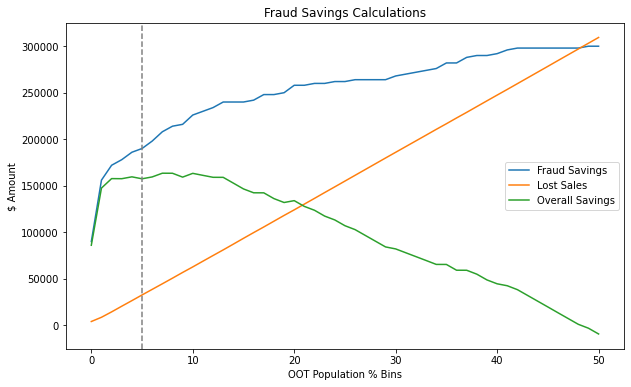

In [765]:
import seaborn
plt.title('Fraud Savings Calculations')
plt.ylabel('$ Amount')
plt.xlabel('OOT Population % Bins')
plt.plot('Bin','CumulativeSavings',data=vizdf3,label='Fraud Savings')
plt.plot('Bin','CumulativeLosses',data=vizdf3,label='Lost Sales')
plt.plot('Bin','CumulativeOverall',data=vizdf3,label='Overall Savings')
plt.axvline(x=5,linestyle='--',color='grey')
plt.legend()
#plt.savefig('savingscals2.png')
plt.show()

In [766]:
final_model = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 50)
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size = .3)
final_model.fit(X_train, y_train)
ootpredictions = final_model.predict(X_oot3)
ootprobs = final_model.predict_proba(X_oot3)
trainpredictions = final_model.predict(X_train)
trainprobs = final_model.predict_proba(X_train)
testpredictions = final_model.predict(X_test)
testprobs = final_model.predict_proba(X_test)

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [767]:
allpredictions = list(trainpredictions) + list(testpredictions) + list(ootpredictions)
allprobs = list(trainprobs) + list(testprobs) + list(ootprobs)

In [768]:
len(data)

96397

In [769]:
len(allprobs)

93059

In [770]:
len(data[data.Date>'2010-01-14'])

93059

In [771]:
lastviz = data[data.Date>'2010-01-14'].copy()

In [772]:
lastviz = lastviz[['Recnum','Cardnum','Date','Merchnum','Amount','Fraud']]

In [773]:
newprobs = [i[1] for i in allprobs]

In [774]:
lastviz['Prob'] = newprobs

In [775]:
lastviz

,Recnum,Cardnum,Date,Merchnum,Amount,Fraud,Prob
3338,3345,5142289869,2010-01-15,602608969534,333.47,0,7.020783e-03
3339,3346,5142148452,2010-01-15,5509006296254,4.37,0,1.328267e-03
3340,3347,5142184598,2010-01-15,680655463,271.93,0,7.083186e-04
3341,3348,5142148452,2010-01-15,5509006296254,3.62,0,1.752956e-22
3342,3349,5142195887,2010-01-15,4503082616100,16.28,0,1.006046e-03
...,...,...,...,...,...,...,...
96392,96749,5142276053,2010-12-31,3500000006160,84.79,0,4.112103e-04
96393,96750,5142225701,2010-12-31,8090710030950,118.75,0,3.085791e-03
96394,96751,5142226486,2010-12-31,4503057341100,363.56,0,6.366279e-02
96395,96752,5142244619,2010-12-31,8834000695412,2202.03,0,2.528124e-02


In [776]:
lastviz.groupby('Cardnum')['Fraud'].sum().sort_values().tail(30)

Cardnum
5142205500     9
5142225942    10
5142232349    10
5142245297    12
5142206786    20
5142249750    24
5142183973    25
5142111125    26
5142189113    27
5142299705    27
5142116864    28
5142176939    28
5142197563    30
5142182128    31
5142197711    32
5142235211    32
5142179617    32
5142152857    32
5142271065    34
5142138135    36
5142847398    37
5142214614    37
5142202847    37
5142220919    38
5142212038    39
5142181728    39
5142160778    40
5142189341    41
5142199009    45
5142140316    46
Name: Fraud, dtype: int64

In [777]:
cardviz = lastviz[lastviz.Cardnum==5142235211]

In [778]:
cardviz['TransactionCount'] = range(1,len(cardviz)+1)

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [779]:
pd.set_option('display.max_rows', 500)
cardviz

,Recnum,Cardnum,Date,Merchnum,Amount,Fraud,Prob,TransactionCount
16216,16237,5142235211,2010-03-07,2094206450000,417.90,0,0.004622,1
16323,16344,5142235211,2010-03-07,809942446330,499.66,0,0.000576,2
16568,16590,5142235211,2010-03-07,3404806002325,491.35,0,0.001520,3
16575,16597,5142235211,2010-03-07,2094206450000,134.35,0,0.001542,4
16928,16952,5142235211,2010-03-08,6000009008310,139.16,0,0.004311,5
17031,17055,5142235211,2010-03-09,61563,507.80,0,0.032417,6
20623,20658,5142235211,2010-03-21,602608969284,334.29,0,0.004221,7
22846,22895,5142235211,2010-03-29,602608969284,17.37,0,0.007903,8
25337,25395,5142235211,2010-04-06,809942446330,35.97,0,0.000109,9
25833,25893,5142235211,2010-04-08,602608969534,488.00,0,0.000076,10


In [780]:
len(cardviz[cardviz.Date=='2010-11-26'])

15

In [781]:
cardviz2 = cardviz[cardviz.Date>'2010-08-14']

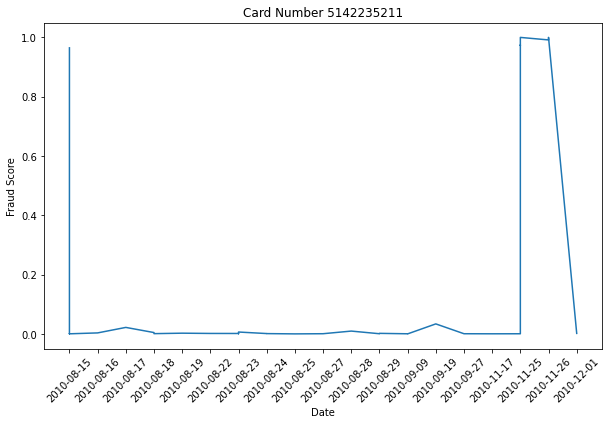

In [782]:
plt.title('Card Number 5142235211')
plt.ylabel('Fraud Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot('Date','Prob',data=cardviz2)
#plt.savefig('score_dates.png')
plt.show()

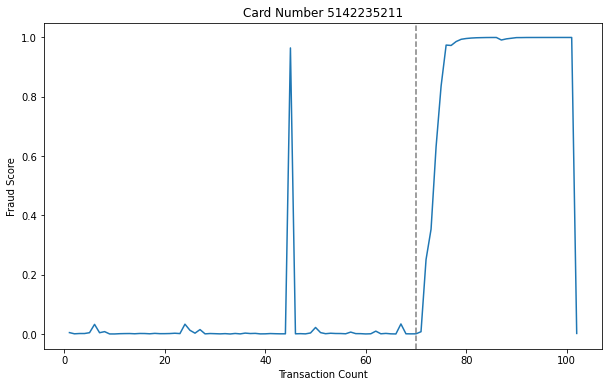

In [783]:
plt.title('Card Number 5142235211')
plt.ylabel('Fraud Score')
plt.xlabel('Transaction Count')
plt.plot('TransactionCount','Prob',data=cardviz)
plt.axvline(x=70,linestyle='--',color='grey')
#plt.savefig('score_trans.png')
plt.show()

69 transactions from (03-07 to 11-17)
17 transactions on 11-25
15 transactions on 11-26

In [784]:
lastviz.groupby('Merchnum')['Fraud'].sum().sort_values().tail(30)

Merchnum
4063000739258      4
5725000466504      4
2094206450000      4
9977060941600      4
4591200814444      7
6929               8
679613867334       8
5000006000095      9
5863604000604     10
9108234610006     10
6170075665        18
6899988049601     18
8292309000040     20
6005030600003     24
92891948003       24
9900020006406     25
6006333528866     27
6070095870009     27
997674930332      29
4503082476300     31
938909877224      32
9108234610000     33
253052983001      33
900009045549      36
618901687330      36
4503738417400     37
4620009957157     39
8834000695423     46
930090121224      53
4353000719908    107
Name: Fraud, dtype: int64

In [785]:
#253052983001
merchviz = lastviz[lastviz.Merchnum=='4353000719908']
merchviz['TransactionCount'] = range(1,len(merchviz)+1)
merchviz

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Recnum,Cardnum,Date,Merchnum,Amount,Fraud,Prob,TransactionCount
3392,3399,5142241068,2010-01-15,4353000719908,65.99,0,0.000330,1
3482,3489,5142216104,2010-01-16,4353000719908,49.49,0,0.010863,2
3725,3732,5142231744,2010-01-18,4353000719908,113.99,0,0.001032,3
3819,3827,5142216104,2010-01-18,4353000719908,49.49,0,0.011273,4
3865,3873,5142192111,2010-01-18,4353000719908,393.91,0,0.004064,5
...,...,...,...,...,...,...,...,...
96174,96530,5142146217,2010-12-30,4353000719908,240.95,0,0.000482,1033
96209,96565,5142190418,2010-12-30,4353000719908,46.94,0,0.000432,1034
96268,96624,5142178848,2010-12-30,4353000719908,18.46,0,0.000855,1035
96316,96672,5142217905,2010-12-30,4353000719908,68.90,0,0.000795,1036


In [786]:
merchviz2 = merchviz[(merchviz.Date>='2010-11-01') & (merchviz.Date<'2010-12-01')]

In [787]:
merchviz2

,Recnum,Cardnum,Date,Merchnum,Amount,Fraud,Prob,TransactionCount
84104,84434,5142170410,2010-11-01,4353000719908,35.94,0,0.000718,843
84124,84454,5142141358,2010-11-01,4353000719908,34.02,0,0.000812,844
84194,84524,5142124208,2010-11-02,4353000719908,421.80,0,0.000516,845
84283,84613,5142224426,2010-11-02,4353000719908,56.95,0,0.006660,846
84341,84671,5142132687,2010-11-02,4353000719908,21.42,0,0.000824,847
84363,84693,5142158538,2010-11-02,4353000719908,78.90,0,0.003790,848
84396,84726,5142152982,2010-11-02,4353000719908,19.91,0,0.013578,849
84416,84747,5142150217,2010-11-03,4353000719908,248.55,0,0.000534,850
84783,85119,5142189945,2010-11-04,4353000719908,10.39,0,0.003779,851
84802,85139,5142170410,2010-11-04,4353000719908,720.05,0,0.004221,852


In [788]:
merchviz2['TransactionCount'] = range(1,len(merchviz2)+1)

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


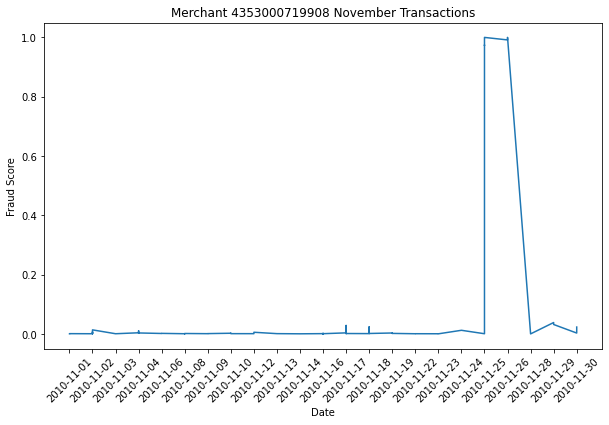

In [789]:
plt.title('Merchant 4353000719908 November Transactions')
plt.ylabel('Fraud Score')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot('Date','Prob',data=merchviz2)
#plt.savefig('merch_dates.png')
plt.show()

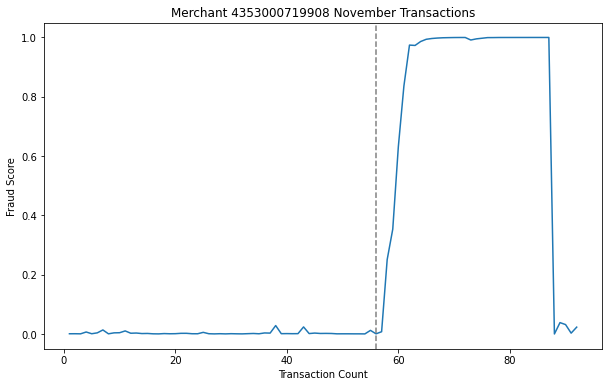

In [790]:
plt.title('Merchant 4353000719908 November Transactions')
plt.ylabel('Fraud Score')
plt.xlabel('Transaction Count')
plt.plot('TransactionCount','Prob',data=merchviz2)
plt.axvline(x=56,linestyle='--',color='grey')
plt.savefig('merch_trans.png')
plt.show()

92 transactions at this merchant in the month of November
From 11/1 to 11/24 they average 2.24 transactions a day
17 transactions on 11/25
15 transactions on 11/26

In [791]:
top20vars

['Cardnum_max_30',
 'card_merchant_max_30',
 'Merchnum_total_3',
 'Cardnum_total_130',
 'Merchnum_mean_7',
 'card_merchant_median_1',
 'Merchnum_mean_3',
 'Cardnum_mean_30',
 'card_merchant_mean_1',
 'card_state_mean_30',
 'card_state_median_30',
 'card_zip_median_1',
 'card_state_mean_14',
 'Cardnum_max_14',
 'card_state_max_0',
 'Cardnum_total_30',
 'card_zip_mean_1',
 'card_state_median_14',
 'card_zip_max_14',
 'card_state_total_30']

In [ ]:
# trainpred
# trainprob
# testpred
# testprob
# ootpred
# ootprob
# y_train
# y_test
# y_oot

### Results for final model (only based off final iteration (not average), reason why numbers are different)

In [886]:
traindf = pd.DataFrame(columns = ['Pred','Prob','Y'])
traindf['Pred'] = trainpred
traindf['Prob'] = [i[1] for i in trainprob]
traindf['Y'] = list(y_train)

traindf = traindf.sort_values(by='Prob',ascending=False)

qc = pd.qcut(range(len(traindf)), q=100, precision=1)
# bin definition
bins  = qc.categories
# bin corresponding to each point in data
codes = qc.codes

traindf['Bin'] = codes
trainresults = pd.DataFrame(columns = ['Bin','#Records', '#Goods', '#Bads','%Goods','%Bads',
                                      'Total # Records','CumGoods','CumBads','Cum%Goods','Cum%Bads',
                                      'FDR','FPR'])

trainresults['Bin'] = list(np.unique(codes))



for i in trainresults.index:
    filt = traindf[traindf.Bin==trainresults.loc[i,'Bin']]
    trainresults.loc[i,'#Records'] = len(filt)
    trainresults.loc[i,'#Goods'] = len(filt[filt.Y==0])
    trainresults.loc[i,'#Bads'] = len(filt[filt.Y==1])
    trainresults.loc[i,'%Goods'] = 100* len(filt[filt.Y==0]) / len(filt)
    trainresults.loc[i,'%Bads'] = 100* len(filt[filt.Y==1]) / len(filt)
    trainresults.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(traindf[traindf.Y==1])
    trainresults.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)]))

trainresults.loc[0,'Total # Records'] = trainresults.loc[0,'#Records']
trainresults.loc[0,'CumGoods'] = trainresults.loc[0,'#Goods']
trainresults.loc[0,'CumBads'] = trainresults.loc[0,'#Bads']
trainresults.loc[0,'Cum%Goods'] = trainresults.loc[0,'%Goods']
trainresults.loc[0,'Cum%Bads'] = trainresults.loc[0,'%Bads']    


for i in range(1,len(trainresults)):
    trainresults.loc[i,'Total # Records'] = trainresults.loc[i,'#Records'] + trainresults.loc[i-1,'Total # Records']
    trainresults.loc[i,'CumGoods'] = trainresults.loc[i,'#Goods'] + trainresults.loc[i-1,'CumGoods']
    trainresults.loc[i,'CumBads'] = trainresults.loc[i,'#Bads'] + trainresults.loc[i-1,'CumBads']
    trainresults.loc[i,'Cum%Goods'] = 100* trainresults.loc[i,'CumGoods'] / trainresults.loc[i,'Total # Records']
    trainresults.loc[i,'Cum%Bads'] = 100* trainresults.loc[i,'CumBads'] / trainresults.loc[i,'Total # Records']
    trainresults.loc[i,'FDR'] = trainresults.loc[i,'FDR'] + trainresults.loc[i-1,'FDR']
    trainresults.loc[i,'FPR'] = trainresults.loc[i,'FPR'] + trainresults.loc[i-1,'FPR']
    
trainresults['Bin'] = trainresults['Bin'] + 1

In [887]:
print('Training Subset')
print(f'# Records:{len(traindf)}, #Goods:{len(traindf[traindf.Y==0])}, #Bads:{len(traindf[traindf.Y==1])}, Fraud Rate:{round(len(traindf[traindf.Y==1])/len(traindf),6)}')
trainresults.head(20)

Training Subset
# Records:56442, #Goods:55830, #Bads:612, Fraud Rate:0.010843


,Bin,#Records,#Goods,#Bads,%Goods,%Bads,Total # Records,CumGoods,CumBads,Cum%Goods,Cum%Bads,FDR,FPR
0,1,565,167,398,29.5575,70.4425,565,167,398,29.5575,70.4425,54.2484,8.38323
1,2,564,504,60,89.3617,10.6383,1129,671,458,59.4331,40.5669,54.2484,8.38323
2,3,565,533,32,94.3363,5.66372,1694,1204,490,71.0744,28.9256,54.2484,8.38323
3,4,564,540,24,95.7447,4.25532,2258,1744,514,77.2365,22.7635,54.2484,8.38323
4,5,565,560,5,99.115,0.884956,2823,2304,519,81.6153,18.3847,54.2484,8.38323
5,6,564,558,6,98.9362,1.06383,3387,2862,525,84.4996,15.5004,54.2484,8.38323
6,7,564,559,5,99.1135,0.886525,3951,3421,530,86.5857,13.4143,54.2484,8.38323
7,8,565,559,6,98.9381,1.06195,4516,3980,536,88.1311,11.8689,54.2484,8.38323
8,9,564,557,7,98.7589,1.24113,5080,4537,543,89.311,10.689,54.2484,8.38323
9,10,565,562,3,99.469,0.530973,5645,5099,546,90.3277,9.67228,54.2484,8.38323


In [888]:
testdf = pd.DataFrame(columns = ['Pred','Prob','Y'])
testdf['Pred'] = testpred
testdf['Prob'] = [i[1] for i in testprob]
testdf['Y'] = list(y_test)

testdf = testdf.sort_values(by='Prob',ascending=False)

qc = pd.qcut(range(len(testdf)), q=100, precision=1)
# bin definition
bins  = qc.categories
# bin corresponding to each point in data
codes = qc.codes

testdf['Bin'] = codes
testresults = pd.DataFrame(columns = ['Bin','#Records', '#Goods', '#Bads','%Goods','%Bads',
                                      'Total # Records','CumGoods','CumBads','Cum%Goods','Cum%Bads',
                                      'FDR','FPR'])

testresults['Bin'] = list(np.unique(codes))



for i in testresults.index:
    filt = testdf[testdf.Bin==testresults.loc[i,'Bin']]
    testresults.loc[i,'#Records'] = len(filt)
    testresults.loc[i,'#Goods'] = len(filt[filt.Y==0])
    testresults.loc[i,'#Bads'] = len(filt[filt.Y==1])
    testresults.loc[i,'%Goods'] = 100* len(filt[filt.Y==0]) / len(filt)
    testresults.loc[i,'%Bads'] = 100* len(filt[filt.Y==1]) / len(filt)
    testresults.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(testdf[testdf.Y==1])
    testresults.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)]))

testresults.loc[0,'Total # Records'] = testresults.loc[0,'#Records']
testresults.loc[0,'CumGoods'] = testresults.loc[0,'#Goods']
testresults.loc[0,'CumBads'] = testresults.loc[0,'#Bads']
testresults.loc[0,'Cum%Goods'] = testresults.loc[0,'%Goods']
testresults.loc[0,'Cum%Bads'] = testresults.loc[0,'%Bads']    


for i in range(1,len(testresults)):
    testresults.loc[i,'Total # Records'] = testresults.loc[i,'#Records'] + testresults.loc[i-1,'Total # Records']
    testresults.loc[i,'CumGoods'] = testresults.loc[i,'#Goods'] + testresults.loc[i-1,'CumGoods']
    testresults.loc[i,'CumBads'] = testresults.loc[i,'#Bads'] + testresults.loc[i-1,'CumBads']
    testresults.loc[i,'Cum%Goods'] = 100* testresults.loc[i,'CumGoods'] / testresults.loc[i,'Total # Records']
    testresults.loc[i,'Cum%Bads'] = 100* testresults.loc[i,'CumBads'] / testresults.loc[i,'Total # Records']
    testresults.loc[i,'FDR'] = testresults.loc[i,'FDR'] + testresults.loc[i-1,'FDR']
    testresults.loc[i,'FPR'] = testresults.loc[i,'FPR'] + testresults.loc[i-1,'FPR']
    
testresults['Bin'] = testresults['Bin'] + 1

In [889]:
print('Testing Subset')
print(f'# Records:{len(testdf)}, #Goods:{len(testdf[testdf.Y==0])}, #Bads:{len(testdf[testdf.Y==1])}, Fraud Rate:{round(len(testdf[testdf.Y==1])/len(testdf),6)}')
testresults.head(20)

Testing Subset
# Records:24190, #Goods:23934, #Bads:256, Fraud Rate:0.010583


,Bin,#Records,#Goods,#Bads,%Goods,%Bads,Total # Records,CumGoods,CumBads,Cum%Goods,Cum%Bads,FDR,FPR
0,1,242,103,139,42.562,57.438,242,103,139,42.562,57.438,41.4062,11.6505
1,2,242,221,21,91.3223,8.67769,484,324,160,66.9421,33.0579,41.4062,11.6505
2,3,242,225,17,92.9752,7.02479,726,549,177,75.6198,24.3802,41.4062,11.6505
3,4,242,236,6,97.5207,2.47934,968,785,183,81.095,18.905,41.4062,11.6505
4,5,242,236,6,97.5207,2.47934,1210,1021,189,84.3802,15.6198,41.4062,11.6505
5,6,242,236,6,97.5207,2.47934,1452,1257,195,86.5702,13.4298,41.4062,11.6505
6,7,242,241,1,99.5868,0.413223,1694,1498,196,88.4298,11.5702,41.4062,11.6505
7,8,242,240,2,99.1736,0.826446,1936,1738,198,89.7727,10.2273,41.4062,11.6505
8,9,242,237,5,97.9339,2.06612,2178,1975,203,90.6795,9.32048,41.4062,11.6505
9,10,241,239,2,99.1701,0.829876,2419,2214,205,91.5254,8.47458,41.4062,11.6505


In [890]:
ootdf = pd.DataFrame(columns = ['Pred','Prob','Y'])
ootdf['Pred'] = ootpred
ootdf['Prob'] = [i[1] for i in ootprob]
ootdf['Y'] = list(y_oot)

ootdf = ootdf.sort_values(by='Prob',ascending=False)

qc = pd.qcut(range(len(ootdf)), q=100, precision=1)
# bin definition
bins  = qc.categories
# bin corresponding to each point in data
codes = qc.codes

ootdf['Bin'] = codes
ootresults = pd.DataFrame(columns = ['Bin','#Records', '#Goods', '#Bads','%Goods','%Bads',
                                      'Total # Records','CumGoods','CumBads','Cum%Goods','Cum%Bads',
                                      'FDR','FPR'])

ootresults['Bin'] = list(np.unique(codes))



for i in ootresults.index:
    filt = ootdf[ootdf.Bin==ootresults.loc[i,'Bin']]
    ootresults.loc[i,'#Records'] = len(filt)
    ootresults.loc[i,'#Goods'] = len(filt[filt.Y==0])
    ootresults.loc[i,'#Bads'] = len(filt[filt.Y==1])
    ootresults.loc[i,'%Goods'] = 100* len(filt[filt.Y==0]) / len(filt)
    ootresults.loc[i,'%Bads'] = 100* len(filt[filt.Y==1]) / len(filt)
    ootresults.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(ootdf[ootdf.Y==1])
    ootresults.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)]))

ootresults.loc[0,'Total # Records'] = ootresults.loc[0,'#Records']
ootresults.loc[0,'CumGoods'] = ootresults.loc[0,'#Goods']
ootresults.loc[0,'CumBads'] = ootresults.loc[0,'#Bads']
ootresults.loc[0,'Cum%Goods'] = ootresults.loc[0,'%Goods']
ootresults.loc[0,'Cum%Bads'] = ootresults.loc[0,'%Bads']    


for i in range(1,len(ootresults)):
    ootresults.loc[i,'Total # Records'] = ootresults.loc[i,'#Records'] + ootresults.loc[i-1,'Total # Records']
    ootresults.loc[i,'CumGoods'] = ootresults.loc[i,'#Goods'] + ootresults.loc[i-1,'CumGoods']
    ootresults.loc[i,'CumBads'] = ootresults.loc[i,'#Bads'] + ootresults.loc[i-1,'CumBads']
    ootresults.loc[i,'Cum%Goods'] = 100* ootresults.loc[i,'CumGoods'] / ootresults.loc[i,'Total # Records']
    ootresults.loc[i,'Cum%Bads'] = 100* ootresults.loc[i,'CumBads'] / ootresults.loc[i,'Total # Records']
    ootresults.loc[i,'FDR'] = ootresults.loc[i,'FDR'] + ootresults.loc[i-1,'FDR']
    ootresults.loc[i,'FPR'] = ootresults.loc[i,'FPR'] + ootresults.loc[i-1,'FPR']
    
ootresults['Bin'] = ootresults['Bin'] + 1

In [891]:
print('OOT Subset')
print(f'# Records:{len(ootdf)}, #Goods:{len(ootdf[ootdf.Y==0])}, #Bads:{len(ootdf[ootdf.Y==1])}, Fraud Rate:{round(len(ootdf[ootdf.Y==1])/len(ootdf),6)}')
ootresults.head(20)

OOT Subset
# Records:12427, #Goods:12248, #Bads:179, Fraud Rate:0.014404


,Bin,#Records,#Goods,#Bads,%Goods,%Bads,Total # Records,CumGoods,CumBads,Cum%Goods,Cum%Bads,FDR,FPR
0,1,125,87,38,69.6,30.4,125,87,38,69.6,30.4,20.1117,71.2644
1,2,124,91,33,73.3871,26.6129,249,178,71,71.4859,28.5141,20.1117,71.2644
2,3,124,101,23,81.4516,18.5484,373,279,94,74.7989,25.2011,20.1117,71.2644
3,4,125,119,6,95.2,4.8,498,398,100,79.9197,20.0803,20.1117,71.2644
4,5,124,119,5,95.9677,4.03226,622,517,105,83.119,16.881,20.1117,71.2644
5,6,124,118,6,95.1613,4.83871,746,635,111,85.1206,14.8794,20.1117,71.2644
6,7,124,122,2,98.3871,1.6129,870,757,113,87.0115,12.9885,20.1117,71.2644
7,8,125,119,6,95.2,4.8,995,876,119,88.0402,11.9598,20.1117,71.2644
8,9,124,123,1,99.1935,0.806452,1119,999,120,89.2761,10.7239,20.1117,71.2644
9,10,124,122,2,98.3871,1.6129,1243,1121,122,90.185,9.81496,20.1117,71.2644


### Results for final model (retrained on all modeling data, tested on oot data)

In [895]:
# trainpred
# trainprob
# testpred
# testprob
# y
# y_oot

final_model2 = MLPClassifier(hidden_layer_sizes = (40,), max_iter = 50)
final_model2.fit(X3, y)
train2pred = final_model2.predict(X3)
train2prob = final_model2.predict_proba(X3)
test2pred = final_model2.predict(X_oot3)
test2prob = final_model2.predict_proba(X_oot3)

/Users/alekcarlson/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [905]:
train2df = pd.DataFrame(columns = ['Pred','Prob','Y'])
train2df['Pred'] = train2pred
train2df['Prob'] = [i[1] for i in train2prob]
train2df['Y'] = list(y)

train2df = train2df.sort_values(by='Prob',ascending=False)

qc = pd.qcut(range(len(train2df)), q=100, precision=1)
# bin definition
bins  = qc.categories
# bin corresponding to each point in data
codes = qc.codes

train2df['Bin'] = codes
train2results = pd.DataFrame(columns = ['Bin','#Records', '#Goods', '#Bads','%Goods','%Bads',
                                      'Total # Records','CumGoods','CumBads','Cum%Goods','Cum%Bads',
                                      'FDR','FPR'])

train2results['Bin'] = list(np.unique(codes))



for i in train2results.index:
    filt = train2df[train2df.Bin==train2results.loc[i,'Bin']]
    train2results.loc[i,'#Records'] = len(filt)
    train2results.loc[i,'#Goods'] = len(filt[filt.Y==0])
    train2results.loc[i,'#Bads'] = len(filt[filt.Y==1])
    train2results.loc[i,'%Goods'] = 100* len(filt[filt.Y==0]) / len(filt)
    train2results.loc[i,'%Bads'] = 100* len(filt[filt.Y==1]) / len(filt)
    #train2results.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(train2df[train2df.Y==1])
    #train2results.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)]))

train2results.loc[0,'Total # Records'] = train2results.loc[0,'#Records']
train2results.loc[0,'CumGoods'] = train2results.loc[0,'#Goods']
train2results.loc[0,'CumBads'] = train2results.loc[0,'#Bads']
train2results.loc[0,'Cum%Goods'] = train2results.loc[0,'%Goods']
train2results.loc[0,'Cum%Bads'] = train2results.loc[0,'%Bads']    


for i in range(1,len(train2results)):
    train2results.loc[i,'Total # Records'] = train2results.loc[i,'#Records'] + train2results.loc[i-1,'Total # Records']
    train2results.loc[i,'CumGoods'] = train2results.loc[i,'#Goods'] + train2results.loc[i-1,'CumGoods']
    train2results.loc[i,'CumBads'] = train2results.loc[i,'#Bads'] + train2results.loc[i-1,'CumBads']
    train2results.loc[i,'Cum%Goods'] = 100* train2results.loc[i,'CumGoods'] / train2results.loc[i,'Total # Records']
    train2results.loc[i,'Cum%Bads'] = 100* train2results.loc[i,'CumBads'] / train2results.loc[i,'Total # Records']
    #train2results.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(train2df[train2df.Y==1]) + train2results.loc[i-1,'FDR']
    #train2results.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)])) + train2results.loc[i-1,'FPR']
    
train2results['Bin'] = train2results['Bin'] + 1

In [906]:
print('Training Subset')
print(f'# Records:{len(train2df)}, #Goods:{len(train2df[train2df.Y==0])}, #Bads:{len(train2df[train2df.Y==1])}, Fraud Rate:{round(len(train2df[train2df.Y==1])/len(train2df),6)}')
train2results.head(20)

Training Subset
# Records:80632, #Goods:79764, #Bads:868, Fraud Rate:0.010765


,Bin,#Records,#Goods,#Bads,%Goods,%Bads,Total # Records,CumGoods,CumBads,Cum%Goods,Cum%Bads,FDR,FPR
0,1,807,261,546,32.342,67.658,807,261,546,32.342,67.658,NaN,NaN
1,2,806,721,85,89.4541,10.5459,1613,982,631,60.8803,39.1197,NaN,NaN
2,3,806,759,47,94.1687,5.83127,2419,1741,678,71.9719,28.0281,NaN,NaN
3,4,807,786,21,97.3978,2.60223,3226,2527,699,78.3323,21.6677,NaN,NaN
4,5,806,789,17,97.8908,2.10918,4032,3316,716,82.2421,17.7579,NaN,NaN
5,6,806,788,18,97.7667,2.23325,4838,4104,734,84.8284,15.1716,NaN,NaN
6,7,807,794,13,98.3891,1.6109,5645,4898,747,86.7671,13.2329,NaN,NaN
7,8,806,799,7,99.1315,0.868486,6451,5697,754,88.3119,11.6881,NaN,NaN
8,9,806,796,10,98.7593,1.24069,7257,6493,764,89.4722,10.5278,NaN,NaN
9,10,807,805,2,99.7522,0.247831,8064,7298,766,90.501,9.49901,NaN,NaN


In [904]:
test2df = pd.DataFrame(columns = ['Pred','Prob','Y'])
test2df['Pred'] = test2pred
test2df['Prob'] = [i[1] for i in test2prob]
test2df['Y'] = list(y_oot)

test2df = test2df.sort_values(by='Prob',ascending=False)

qc = pd.qcut(range(len(test2df)), q=100, precision=1)
# bin definition
bins  = qc.categories
# bin corresponding to each point in data
codes = qc.codes

test2df['Bin'] = codes
test2results = pd.DataFrame(columns = ['Bin','#Records', '#Goods', '#Bads','%Goods','%Bads',
                                      'Total # Records','CumGoods','CumBads','Cum%Goods','Cum%Bads',
                                      'FDR','FPR'])

test2results['Bin'] = list(np.unique(codes))



for i in test2results.index:
    filt = test2df[test2df.Bin==test2results.loc[i,'Bin']]
    test2results.loc[i,'#Records'] = len(filt)
    test2results.loc[i,'#Goods'] = len(filt[filt.Y==0])
    test2results.loc[i,'#Bads'] = len(filt[filt.Y==1])
    test2results.loc[i,'%Goods'] = 100* len(filt[filt.Y==0]) / len(filt)
    test2results.loc[i,'%Bads'] = 100* len(filt[filt.Y==1]) / len(filt)
    #test2results.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(filt[test2df.Y==1])
    #test2results.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)]))

test2results.loc[0,'Total # Records'] = test2results.loc[0,'#Records']
test2results.loc[0,'CumGoods'] = test2results.loc[0,'#Goods']
test2results.loc[0,'CumBads'] = test2results.loc[0,'#Bads']
test2results.loc[0,'Cum%Goods'] = test2results.loc[0,'%Goods']
test2results.loc[0,'Cum%Bads'] = test2results.loc[0,'%Bads']    


for i in range(1,len(test2results)):
    test2results.loc[i,'Total # Records'] = test2results.loc[i,'#Records'] + test2results.loc[i-1,'Total # Records']
    test2results.loc[i,'CumGoods'] = test2results.loc[i,'#Goods'] + test2results.loc[i-1,'CumGoods']
    test2results.loc[i,'CumBads'] = test2results.loc[i,'#Bads'] + test2results.loc[i-1,'CumBads']
    test2results.loc[i,'Cum%Goods'] = 100* test2results.loc[i,'CumGoods'] / test2results.loc[i,'Total # Records']
    test2results.loc[i,'Cum%Bads'] = 100* test2results.loc[i,'CumBads'] / test2results.loc[i,'Total # Records']
    #test2results.loc[i,'FDR'] = 100*len(filt[(filt.Pred==1)&(filt.Y==1)]) / len(test2df[test2df.Y==1]) + test2results.loc[i-1,'FDR']
    #test2results.loc[i,'FPR'] = 100* len(filt[(filt.Pred==1)&(filt.Y==0)]) / (len(filt[(filt.Pred==1)&(filt.Y==0)]) + len(filt[(filt.Pred==0)&(filt.Y==0)])) + test2results.loc[i-1,'FPR']
    
test2results['Bin'] = test2results['Bin'] + 1


print('Testing Subset')
print(f'# Records:{len(test2df)}, #Goods:{len(test2df[test2df.Y==0])}, #Bads:{len(test2df[test2df.Y==1])}, Fraud Rate:{round(len(test2df[test2df.Y==1])/len(test2df),6)}')
test2results.head(20)

Testing Subset
# Records:12427, #Goods:12248, #Bads:179, Fraud Rate:0.014404


,Bin,#Records,#Goods,#Bads,%Goods,%Bads,Total # Records,CumGoods,CumBads,Cum%Goods,Cum%Bads,FDR,FPR
0,1,125,72,53,57.6,42.4,125,72,53,57.6,42.4,NaN,NaN
1,2,124,115,9,92.7419,7.25806,249,187,62,75.1004,24.8996,NaN,NaN
2,3,124,101,23,81.4516,18.5484,373,288,85,77.2118,22.7882,NaN,NaN
3,4,125,109,16,87.2,12.8,498,397,101,79.7189,20.2811,NaN,NaN
4,5,124,121,3,97.5806,2.41935,622,518,104,83.2797,16.7203,NaN,NaN
5,6,124,120,4,96.7742,3.22581,746,638,108,85.5228,14.4772,NaN,NaN
6,7,124,122,2,98.3871,1.6129,870,760,110,87.3563,12.6437,NaN,NaN
7,8,125,122,3,97.6,2.4,995,882,113,88.6432,11.3568,NaN,NaN
8,9,124,120,4,96.7742,3.22581,1119,1002,117,89.5442,10.4558,NaN,NaN
9,10,124,122,2,98.3871,1.6129,1243,1124,119,90.4264,9.57361,NaN,NaN
